# Deep Learning
## Practice Projects
# P2: Multi-Label Classification

## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. The command hide_code will hide the code cells.

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


In [3]:
hide_code
# Plot the neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## Step 1. Load and Explore the Data
For this project, I have created two datasets of color images (32x32x3) with 33 handwritten letters.


Run the following cells to download the data.

In [4]:
hide_code
# Function for processing an image
def image_to_tensor(img_path, folder_path):
    img = keras_image.load_img(folder_path + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths, folder_path):
    list_of_tensors = [image_to_tensor(img_path, folder_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [5]:
hide_code
# Load the dataset #1
data = pd.read_csv("data/letters.csv")
files = data['file']
letters = data['letter']
backgrounds = data['background'].values
targets = data['label'].values
tensors = data_to_tensor(files, "data/");

100%|██████████| 1650/1650 [02:20<00:00, 11.73it/s]


In [6]:
hide_code
# Load the dataset #2
data2 = pd.read_csv("data2/letters2.csv")
files2 = data2['file']
letters2 = data2['letter']
backgrounds2 = data2['background'].values
targets2 = data2['label'].values
tensors2 = data_to_tensor(files2, "data2/");

100%|██████████| 5940/5940 [11:09<00:00,  8.87it/s]


In [7]:
hide_code
# Load the dataset #3
data3 = pd.read_csv("data3/letters3.csv")
files3 = data3['file']
letters3 = data3['letter']
backgrounds3 = data3['background'].values
targets3 = data3['label'].values
tensors3 = data_to_tensor(files3, "data3/");

100%|██████████| 6600/6600 [10:18<00:00, 10.67it/s]


In [8]:
hide_code
# Print the shape 
print ('Tensor #1 shape:', tensors.shape)
print ('Target #1 shape', targets.shape)
print ('Tensor #2 shape:', tensors2.shape)
print ('Target #2 shape', targets2.shape)
print ('Tensor #3 shape:', tensors3.shape)
print ('Target #3 shape', targets3.shape)

Tensor #1 shape: (1650, 32, 32, 3)
Target #1 shape (1650,)
Tensor #2 shape: (5940, 32, 32, 3)
Target #2 shape (5940,)
Tensor #3 shape: (6600, 32, 32, 3)
Target #3 shape (6600,)


In [9]:
hide_code
# Concatenate arrays
tensors = np.concatenate((tensors, tensors2), axis=0)
targets = np.concatenate((targets, targets2), axis=0)
backgrounds = np.concatenate((backgrounds, backgrounds2), axis=0)
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (7590, 32, 32, 3)
Target shape (7590,)
Background shape: (7590,)


In [10]:
hide_code
# Concatenate arrays
tensors = np.concatenate((tensors, tensors3), axis=0)
targets = np.concatenate((targets, targets3), axis=0)
backgrounds = np.concatenate((backgrounds, backgrounds3), axis=0)
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (14190, 32, 32, 3)
Target shape (14190,)
Background shape: (14190,)


In [11]:
hide_code
# Concatenate series
letters = pd.concat((letters, letters2), axis=0, ignore_index=True)
letters = pd.concat((letters, letters3), axis=0, ignore_index=True)
len(letters)

14190

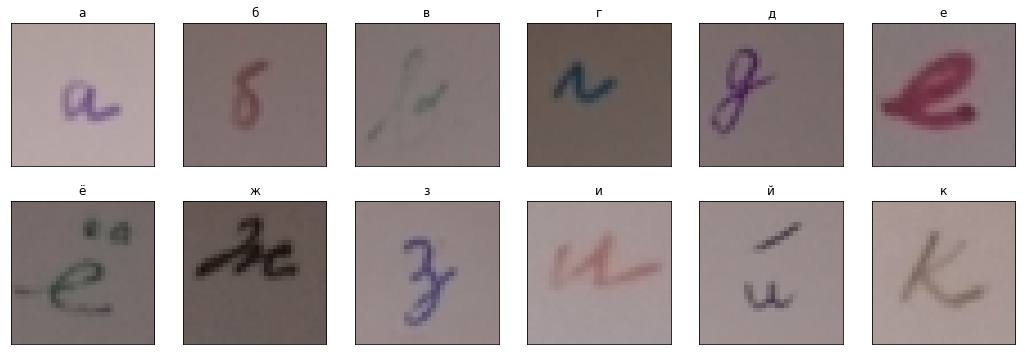

In [12]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data2/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters2[i*180])
    display_images(files2[i*180], ax)

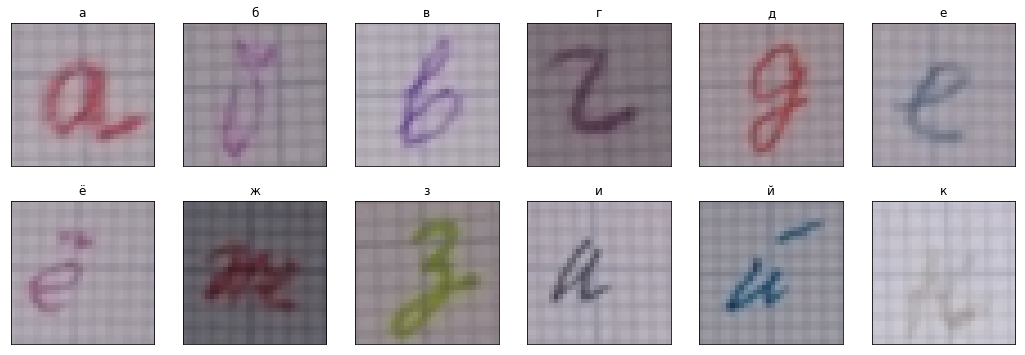

In [13]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data3/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters3[i*200])
    display_images(files3[i*200], ax)

## Step 2. Save and Load the Data
The data tensors can be saved in the appropriate format of files .h5.

In [15]:
hide_code
# Create the tensor file
with h5py.File('LetterColorImages_123.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.create_dataset('backgrounds', data = backgrounds)
    f.close()

In [16]:
hide_code
# Create the tensor file
with h5py.File('LetterColorImages3.h5', 'w') as f:
    f.create_dataset('images', data = tensors3)
    f.create_dataset('labels', data = targets3)
    f.create_dataset('backgrounds', data = backgrounds3)
    f.close()

In [17]:
hide_code
# Read the h5 file
f = h5py.File('LetterColorImages_123.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [18]:
hide_code
# Create tensors and targets
backgrounds = np.array(f[keys[0]])
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (14190, 32, 32, 3)
Target shape (14190,)
Background shape: (14190,)


In [19]:
hide_code
# Create a csv file
images_csv = tensors.reshape(-1,32*32*3)
np.savetxt("letter_images.csv", images_csv, fmt='%i', delimiter=",")

In [20]:
hide_code
# Read the pandas dataframe from csv
data_images = pd.read_csv("letter_images.csv", header=None)
data_images.iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
0,196,186,203,196,188,203,194,187,202,194
1,179,173,183,181,174,186,182,175,185,179
2,179,164,164,181,168,168,182,169,168,182
3,177,161,167,175,162,167,173,160,165,176
4,154,149,156,157,151,159,157,149,157,157
5,252,242,233,252,242,233,254,244,235,255
6,176,169,179,177,170,180,177,170,180,178
7,200,197,214,201,198,217,202,199,218,202
8,252,240,233,253,242,235,253,241,234,252
9,178,170,177,178,170,176,176,169,178,179


In [22]:
hide_code
# Read image tensors from the dataframe
tensors = data_images.values
tensors = tensors.reshape(14190,32,32,3)

## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [14]:
hide_code
# Normalize the tensors
tensors = tensors.astype('float32')/255

Label:  я


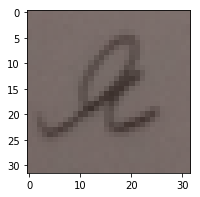

In [15]:
hide_code
# Read and display a tensor using Matplotlib
print('Label: ', letters[7500])
plt.figure(figsize=(3,3))
plt.imshow(tensors[7500]);

Create tensors of grayscaled images and display their shape.

In [16]:
hide_code
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (14190, 32, 32)


Label:  я


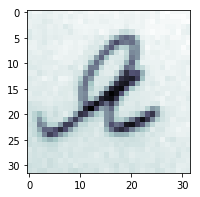

In [17]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Label: ', letters[7500])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[7500], cmap=cm.bone);

### One-hot encode
Now we'll implement the one-hot encoding function to_categorical.

In [18]:
hide_code
# Print the target unique values
print('backgrounds:', set(backgrounds))
print('targets:', set(targets))

backgrounds: {0, 1, 2, 3}
targets: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [19]:
hide_code
# One-hot encode the background targets
backgrounds = to_categorical(backgrounds, 4)
backgrounds.shape

(14190, 4)

In [20]:
hide_code
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(14190, 33)

### Add background

In [21]:
hide_code
# Create multi-label targets
back_targets = np.concatenate((cat_targets, backgrounds), axis=1)
back_targets.shape

(14190, 37)

### Split
#### Color Images
Apply the function train_test_split and split the data into training and testing sets. 

Set up the size for the test set - 10% and for the validation set - 10%.

In [22]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [23]:
hide_code
# Print the shape
x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape

((11352, 32, 32, 3),
 (1419, 32, 32, 3),
 (1419, 32, 32, 3),
 (11352, 33),
 (1419, 33),
 (1419, 33))

#### Grayscaled Images

In [24]:
hide_code
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, cat_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [25]:
hide_code
# Reshape the grayscaled data
x_train2, x_test2, x_valid2 = \
x_train2.reshape(-1, 32, 32, 1), x_test2.reshape(-1, 32, 32, 1), x_valid2.reshape(-1, 32, 32, 1)

In [26]:
hide_code
# Print the shape
x_train2.shape, x_valid2.shape, x_test2.shape, y_train2.shape, y_valid2.shape, y_test2.shape

((11352, 32, 32, 1),
 (1419, 32, 32, 1),
 (1419, 32, 32, 1),
 (11352, 33),
 (1419, 33),
 (1419, 33))

In [29]:
hide_code
# Convert images from grayscaled to RGB
x_train2_tensor = tf.image.grayscale_to_rgb(x_train2, name=None)
x_test2_tensor = tf.image.grayscale_to_rgb(x_test2, name=None)
x_valid2_tensor = tf.image.grayscale_to_rgb(x_valid2, name=None)
# Run tensorflow session
sess = tf.Session()
with sess.as_default():
    x_train2_color = x_train2_tensor.eval()
    x_test2_color = x_test2_tensor.eval()
    x_valid2_color = x_valid2_tensor.eval()
# Check the shape    
x_train2_color.shape, x_test2_color.shape, x_valid2_color.shape

((11352, 32, 32, 3), (1419, 32, 32, 3), (1419, 32, 32, 3))

#### Multi-label targets, color images

In [27]:
hide_code
# Split with multi-label targets
x_train3, x_test3, y_train3, y_test3 = train_test_split(tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]

In [28]:
hide_code
# Print the shape
x_train3.shape, x_valid3.shape, x_test3.shape, y_train3.shape, y_valid3.shape, y_test3.shape

((11352, 32, 32, 3),
 (1419, 32, 32, 3),
 (1419, 32, 32, 3),
 (11352, 37),
 (1419, 37),
 (1419, 37))

In [29]:
hide_code
# Create a list of targets
y_train3_list = [y_train3[:, :33], y_train3[:, 33:]]
y_test3_list = [y_test3[:, :33], y_valid3[:, 33:]]
y_valid3_list = [y_valid3[:, :33], y_valid3[:, 33:]]

#### Multi-label targets, grayscaled images

In [34]:
hide_code
# Split the grayscaled data
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]

In [35]:
hide_code
# Reshape the grayscaled data
x_train4, x_test4, x_valid4 = \
x_train4.reshape(-1, 32, 32, 1), x_test4.reshape(-1, 32, 32, 1), x_valid4.reshape(-1, 32, 32, 1)

In [36]:
hide_code
# Print the shape
x_train4.shape, x_valid4.shape, x_test4.shape, y_train4.shape, y_valid4.shape, y_test4.shape

((11352, 32, 32, 1),
 (1419, 32, 32, 1),
 (1419, 32, 32, 1),
 (11352, 37),
 (1419, 37),
 (1419, 37))

In [37]:
hide_code
# Create a list of targets
y_train4_list = [y_train4[:, :33], y_train4[:, 33:]]
y_test4_list = [y_test4[:, :33], y_test4[:, 33:]]
y_valid4_list = [y_valid4[:, :33], y_valid4[:, 33:]]

## Step 4. Create a One-Label Classification Model
### Color Images
Define a model architecture and compile the model for color images.

In [47]:
hide_code
def model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [48]:
hide_code
# Create callbacks
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.5)

In [49]:
hide_code
# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=64, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, lr_reduction])

Train on 11352 samples, validate on 1419 samples
Epoch 1/100
 - 80s - loss: 3.4902 - acc: 0.0334 - val_loss: 3.4656 - val_acc: 0.0324

Epoch 00001: val_loss improved from inf to 3.46558, saving model to weights.best.model.hdf5
Epoch 2/100
 - 83s - loss: 3.3618 - acc: 0.0632 - val_loss: 3.3205 - val_acc: 0.0726

Epoch 00002: val_loss improved from 3.46558 to 3.32055, saving model to weights.best.model.hdf5
Epoch 3/100
 - 66s - loss: 3.2348 - acc: 0.0785 - val_loss: 3.1811 - val_acc: 0.0853

Epoch 00003: val_loss improved from 3.32055 to 3.18108, saving model to weights.best.model.hdf5
Epoch 4/100
 - 65s - loss: 3.1557 - acc: 0.0814 - val_loss: 3.1800 - val_acc: 0.0916

Epoch 00004: val_loss improved from 3.18108 to 3.18000, saving model to weights.best.model.hdf5
Epoch 5/100
 - 66s - loss: 3.0939 - acc: 0.0921 - val_loss: 3.0863 - val_acc: 0.0902

Epoch 00005: val_loss improved from 3.18000 to 3.08626, saving model to weights.best.model.hdf5
Epoch 6/100
 - 63s - loss: 3.0717 - acc: 0.09

Epoch 49/100
 - 67s - loss: 0.5569 - acc: 0.8222 - val_loss: 0.4356 - val_acc: 0.8781

Epoch 00049: val_loss improved from 0.45044 to 0.43555, saving model to weights.best.model.hdf5
Epoch 50/100
 - 69s - loss: 0.5500 - acc: 0.8238 - val_loss: 0.5336 - val_acc: 0.8344

Epoch 00050: val_loss did not improve from 0.43555
Epoch 51/100
 - 80s - loss: 0.5608 - acc: 0.8221 - val_loss: 0.4352 - val_acc: 0.8739

Epoch 00051: val_loss improved from 0.43555 to 0.43516, saving model to weights.best.model.hdf5
Epoch 52/100
 - 74s - loss: 0.5192 - acc: 0.8354 - val_loss: 0.4382 - val_acc: 0.8746

Epoch 00052: val_loss did not improve from 0.43516
Epoch 53/100
 - 67s - loss: 0.5107 - acc: 0.8384 - val_loss: 0.4516 - val_acc: 0.8774

Epoch 00053: val_loss did not improve from 0.43516
Epoch 54/100
 - 68s - loss: 0.5475 - acc: 0.8239 - val_loss: 0.4734 - val_acc: 0.8584

Epoch 00054: val_loss did not improve from 0.43516
Epoch 55/100
 - 69s - loss: 0.5068 - acc: 0.8396 - val_loss: 0.4168 - val_acc: 0.8

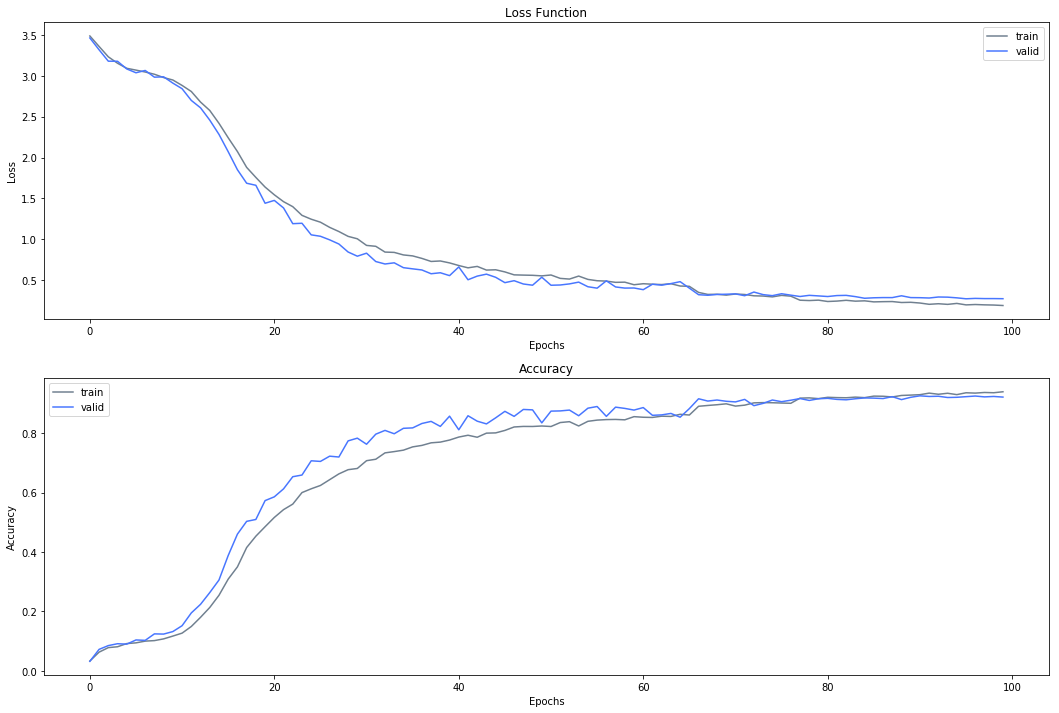

In [50]:
hide_code
# Plot the training history
history_plot(history, 0)

We should have an accuracy greater than 3%

In [51]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

1419/1419 [==============================] - 3s 2ms/step


[0.24738302888838315, 0.9238900634249472]

Apply the ImageDataGenerator() function.

In [52]:
hide_code
# Fit the model with ImageDataGenerator()
# TODO: Define parameters
steps, epochs = 1000, 20
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

generator = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                steps_per_epoch = steps, epochs = epochs,
                                validation_data = (x_valid, y_valid), 
                                callbacks=[checkpointer, lr_reduction], verbose=2)

Epoch 1/20
 - 463s - loss: 0.6433 - acc: 0.8049 - val_loss: 0.3001 - val_acc: 0.9168

Epoch 00001: val_loss did not improve from 0.26913
Epoch 2/20
 - 425s - loss: 0.6010 - acc: 0.8162 - val_loss: 0.2920 - val_acc: 0.9204

Epoch 00002: val_loss did not improve from 0.26913
Epoch 3/20
 - 455s - loss: 0.5854 - acc: 0.8176 - val_loss: 0.2970 - val_acc: 0.9239

Epoch 00003: val_loss did not improve from 0.26913
Epoch 4/20
 - 465s - loss: 0.5710 - acc: 0.8226 - val_loss: 0.2865 - val_acc: 0.9197

Epoch 00004: val_loss did not improve from 0.26913
Epoch 5/20
 - 432s - loss: 0.5548 - acc: 0.8271 - val_loss: 0.2854 - val_acc: 0.9168

Epoch 00005: val_loss did not improve from 0.26913
Epoch 6/20
 - 438s - loss: 0.5510 - acc: 0.8274 - val_loss: 0.2846 - val_acc: 0.9175

Epoch 00006: val_loss did not improve from 0.26913
Epoch 7/20
 - 497s - loss: 0.5330 - acc: 0.8337 - val_loss: 0.2803 - val_acc: 0.9211

Epoch 00007: val_loss did not improve from 0.26913
Epoch 8/20
 - 408s - loss: 0.5278 - acc: 

In [53]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

1419/1419 [==============================] - 10s 7ms/step


[0.24499498124984556, 0.923185341789993]

Let's compare the results with classifying algorithms.

In [ ]:
hide_code
# Fit the classifier and get the accuracy score
y_train_c = np.array([np.argmax(y) for y in y_train])
y_test_c = np.array([np.argmax(y) for y in y_test])
clf = GradientBoostingClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf.score(x_test.reshape(-1, 32*32*3), y_test_c)

In [ ]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf2.score(x_test.reshape(-1, 32*32*3), y_test_c)

### Grayscaled Images
Define a model architecture and compile the model for grayscaled images.

In [54]:
hide_code
def gray_model():
    model = Sequential()
    
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02)) 
    model.add(Dropout(0.25)) 
    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.02)) 
    model.add(Dropout(0.25))    

    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

gray_model = gray_model()

In [55]:
hide_code
# Create callbacks
gray_checkpointer = ModelCheckpoint(filepath='weights.best.gray_model.hdf5', 
                                    verbose=2, save_best_only=True)
gray_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=10, verbose=2, factor=0.8)

In [56]:
hide_code
# Train the model
gray_history = gray_model.fit(x_train2, y_train2, 
                              epochs=200, batch_size=64, verbose=0,
                              validation_data=(x_valid2, y_valid2),
                              callbacks=[gray_checkpointer, gray_lr_reduction])


Epoch 00001: val_loss improved from inf to 3.45369, saving model to weights.best.gray_model.hdf5

Epoch 00002: val_loss improved from 3.45369 to 3.40002, saving model to weights.best.gray_model.hdf5

Epoch 00003: val_loss improved from 3.40002 to 3.38329, saving model to weights.best.gray_model.hdf5

Epoch 00004: val_loss did not improve from 3.38329

Epoch 00005: val_loss improved from 3.38329 to 3.37040, saving model to weights.best.gray_model.hdf5

Epoch 00006: val_loss improved from 3.37040 to 2.85877, saving model to weights.best.gray_model.hdf5

Epoch 00007: val_loss improved from 2.85877 to 2.70932, saving model to weights.best.gray_model.hdf5

Epoch 00008: val_loss improved from 2.70932 to 2.15681, saving model to weights.best.gray_model.hdf5

Epoch 00009: val_loss improved from 2.15681 to 2.03639, saving model to weights.best.gray_model.hdf5

Epoch 00010: val_loss improved from 2.03639 to 2.02739, saving model to weights.best.gray_model.hdf5

Epoch 00011: val_loss improved fr


Epoch 00123: val_loss did not improve from 0.30341

Epoch 00124: val_loss did not improve from 0.30341

Epoch 00125: val_loss did not improve from 0.30341

Epoch 00126: val_loss did not improve from 0.30341

Epoch 00127: val_loss did not improve from 0.30341

Epoch 00128: val_loss did not improve from 0.30341

Epoch 00129: val_loss did not improve from 0.30341

Epoch 00130: val_loss did not improve from 0.30341

Epoch 00131: val_loss did not improve from 0.30341

Epoch 00132: val_loss did not improve from 0.30341

Epoch 00132: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 00133: val_loss did not improve from 0.30341

Epoch 00134: val_loss improved from 0.30341 to 0.29877, saving model to weights.best.gray_model.hdf5

Epoch 00135: val_loss did not improve from 0.29877

Epoch 00136: val_loss did not improve from 0.29877

Epoch 00137: val_loss improved from 0.29877 to 0.28750, saving model to weights.best.gray_model.hdf5

Epoch 00138: val_loss did not improve

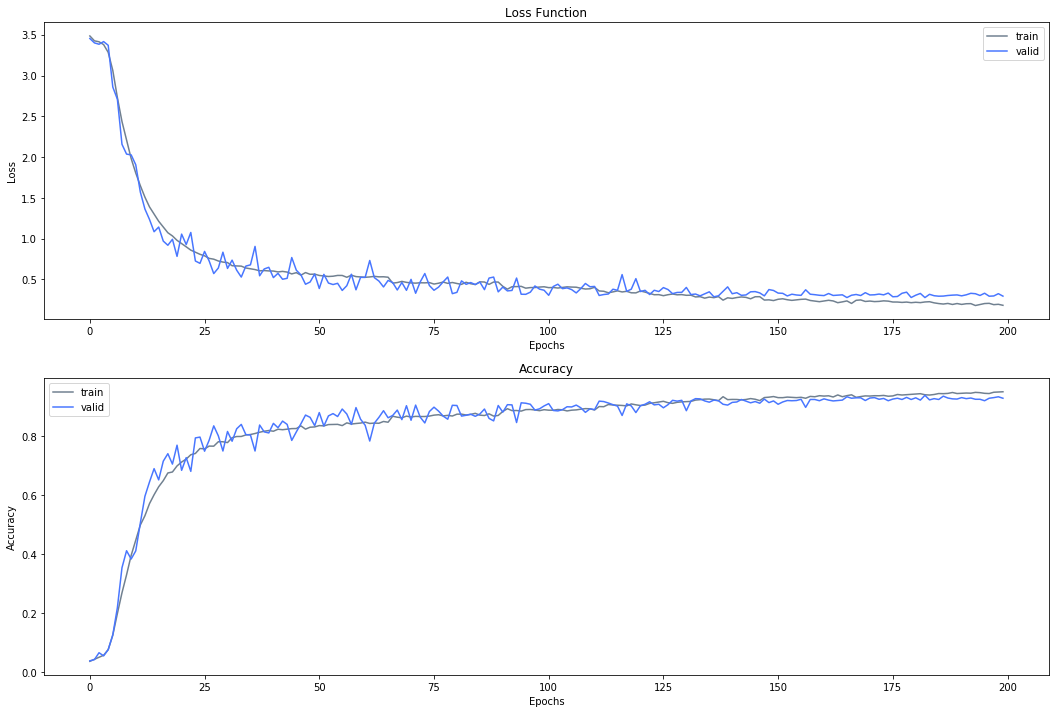

In [57]:
hide_code
# Plot the training history
history_plot(gray_history, 0)

Try to reach an accuracy greater than 80%

In [58]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

1419/1419 [==============================] - 9s 6ms/step


[0.3054520464525246, 0.9295278365045807]

Apply the ImageDataGenerator() function.

In [47]:
hide_code
# Fit the model with ImageDataGenerator()
# TODO: Define parameters
steps, epochs = 1000, 20
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

gray_generator = gray_model.fit_generator(data_generator.flow(x_train2, y_train2, batch_size=64),
                                          steps_per_epoch = steps, epochs = epochs,
                                          validation_data = (x_test2, y_test2), 
                                          callbacks=[gray_checkpointer], verbose=2)

Epoch 1/20

Epoch 00001: val_loss did not improve
 - 576s - loss: 1.7627 - acc: 0.5516 - val_loss: 0.8374 - val_acc: 0.7752
Epoch 2/20

Epoch 00002: val_loss did not improve
 - 567s - loss: 1.6919 - acc: 0.5692 - val_loss: 0.9914 - val_acc: 0.7350
Epoch 3/20

Epoch 00003: val_loss did not improve
 - 552s - loss: 1.6795 - acc: 0.5702 - val_loss: 0.8412 - val_acc: 0.7780
Epoch 4/20

Epoch 00004: val_loss did not improve
 - 537s - loss: 1.6807 - acc: 0.5694 - val_loss: 0.6908 - val_acc: 0.8309
Epoch 5/20

Epoch 00005: val_loss did not improve
 - 521s - loss: 1.6758 - acc: 0.5731 - val_loss: 0.8094 - val_acc: 0.7928
Epoch 6/20

Epoch 00006: val_loss did not improve
 - 530s - loss: 1.7106 - acc: 0.5644 - val_loss: 0.8367 - val_acc: 0.7942
Epoch 7/20

Epoch 00007: val_loss did not improve
 - 516s - loss: 1.7151 - acc: 0.5676 - val_loss: 0.9911 - val_acc: 0.7533
Epoch 8/20

Epoch 00008: val_loss did not improve
 - 491s - loss: 1.7855 - acc: 0.5500 - val_loss: 0.8528 - val_acc: 0.7667
Epoch 9/

In [48]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

1419/1419 [==============================] - 4s 3ms/step


[0.53796458938451108, 0.86680761099365755]

Let's compare the results with classifying algorithms.

In [ ]:
hide_code
# Fit the classifier and get the accuracy score
y_train2_c = np.array([np.argmax(y) for y in y_train2])
y_test2_c = np.array([np.argmax(y) for y in y_test2])
clf = GradientBoostingClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf.score(x_test2.reshape(-1, 32*32), y_test2_c)

In [ ]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf2.score(x_test2.reshape(-1, 32*32), y_test2_c)

## Step 5. Create a Multi-Label Classification Model
### Color Images

In [103]:
hide_code
def multi_model():    
    model_input = Input(shape=(32, 32, 3))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='tanh')(x)    
    x = Dropout(0.25)(x)
    
    x = Dense(256, activation='tanh')(x)    
    x = Dropout(0.25)(x) 
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

multi_model = multi_model()

In [104]:
hide_code
# Display the model architecture
multi_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 32, 32, 64)   4864        input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 16, 16, 64)   0           conv2d_35[0][0]                  
__________________________________________________________________________________________________
dropout_66 (Dropout)            (None, 16, 16, 64)   0           max_pooling2d_35[0][0]           
__________________________________________________________________________________________________
conv2d_36 

In [105]:
hide_code
# Train the model
multi_checkpointer = ModelCheckpoint(filepath='weights.best.multi.hdf5', 
                                     verbose=2, save_best_only=True)
multi_history = multi_model.fit(x_train3, y_train3_list, 
                                validation_data=(x_test3, y_test3_list), 
                                epochs=10, batch_size=128, verbose=0, 
                                callbacks=[multi_checkpointer])


Epoch 00001: val_loss improved from inf to 4.55754, saving model to weights.best.multi.hdf5

Epoch 00002: val_loss improved from 4.55754 to 4.52434, saving model to weights.best.multi.hdf5

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve


We should have an accuracy greater than 3% for the first target (letter) and greater than 50% for the second target (background).

In [106]:
hide_code
# Load the model with the best validation accuracy
multi_model.load_weights('weights.best.multi.hdf5')
# Calculate classification accuracy on the testing set
multi_scores = multi_model.evaluate(x_test3, y_test3_list, verbose=0)

print("Scores: \n" , (multi_scores))
print("First label. Accuracy: %.2f%%" % (multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (multi_scores[4]*100))

Scores: 
 [4.5243446075891089, 3.4702539126414327, 1.0540906626460753, 0.047921071176885127, 0.45806906284623955]
First label. Accuracy: 4.79%
Second label. Accuracy: 45.81%


### Grayscaled Images

In [76]:
hide_code
def gray_multi_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Dense(256, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(4, activation='softmax')(x)
       
    model = Model(inputs=model_input, outputs=[y1, y2])
    # TODO: Compile the model

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])   
    return model

gray_multi_model = gray_multi_model()

In [77]:
hide_code
# Train the model
gray_multi_checkpointer = ModelCheckpoint(filepath='weights.best.gray_multi.hdf5', 
                                          verbose=2, save_best_only=True)
gray_multi_history = gray_multi_model.fit(x_train4, y_train4_list, 
                                          validation_data=(x_test4, y_test4_list), 
                                          epochs=100, batch_size=128, verbose=0, 
                                          callbacks=[gray_multi_checkpointer])


Epoch 00001: val_loss improved from inf to 4.59080, saving model to weights.best.gray_multi.hdf5

Epoch 00002: val_loss improved from 4.59080 to 4.48156, saving model to weights.best.gray_multi.hdf5

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss improved from 4.48156 to 4.09494, saving model to weights.best.gray_multi.hdf5

Epoch 00005: val_loss improved from 4.09494 to 3.81356, saving model to weights.best.gray_multi.hdf5

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss improved from 3.81356 to 3.66999, saving model to weights.best.gray_multi.hdf5

Epoch 00008: val_loss improved from 3.66999 to 3.46014, saving model to weights.best.gray_multi.hdf5

Epoch 00009: val_loss improved from 3.46014 to 3.36177, saving model to weights.best.gray_multi.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss improved from 3.36177 to 3.21495, saving model to weights.best.gray_multi.hdf5

Epoch 00012: val_loss improved from 3.21495 to 3.09212, saving model t

We should have an accuracy greater than 3% for the first target (letter) and greater than 50% for the second target (background).

In [78]:
hide_code
# Load the model with the best validation accuracy
gray_multi_model.load_weights('weights.best.gray_multi.hdf5')
# Calculate classification accuracy on the testing set
gray_multi_scores = gray_multi_model.evaluate(x_test4, y_test4_list, verbose=0)

print("Scores: \n" , (gray_multi_scores))
print("First label. Accuracy: %.2f%%" % (gray_multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (gray_multi_scores[4]*100))

Scores: 
 [0.44682457501238043, 0.4157445699375561, 0.031080002318923324, 0.87315010591826869, 0.99295278365045803]
First label. Accuracy: 87.32%
Second label. Accuracy: 99.30%


## Step 6. Keras Applications
Choose one of the keras applications and try to reach an accuracy greater than 30%
### Color Images

In [ ]:
# Create bottleneck features
resize_x_train = np.array([scipy.misc.imresize(x_train[i], (139, 139, 3)) 
                           for i in range(0, len(x_train))]).astype('float32')
resize_x_test = np.array([scipy.misc.imresize(x_test[i], (139, 139, 3)) 
                          for i in range(0, len(x_test))]).astype('float32')
resize_x_valid = np.array([scipy.misc.imresize(x_valid[i], (139, 139, 3)) 
                          for i in range(0, len(x_valid))]).astype('float32')

iv3_x_train = preprocess_input(resize_x_train)
iv3_x_test = preprocess_input(resize_x_test)
iv3_x_valid = preprocess_input(resize_x_valid)

iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x_train_bn = iv3_base_model.predict(iv3_x_train)
x_test_bn = iv3_base_model.predict(iv3_x_test)
x_valid_bn = iv3_base_model.predict(iv3_x_valid)

In [ ]:
# Save bottleneck features
x_train_bn = np.squeeze(x_train_bn)
x_test_bn = np.squeeze(x_test_bn)
x_valid_bn = np.squeeze(x_valid_bn)

np.save('x_train_bn.npy', x_train_bn)
np.save('x_test_bn.npy', x_test_bn)
np.save('x_valid_bn.npy', x_valid_bn)

In [ ]:
# Load bottleneck features
x_train_bn = np.load('x_train_bn.npy')
x_test_bn = np.load('x_test_bn.npy')
x_valid_bn = np.load('x_valid_bn.npy')

In [ ]:
hide_code
def iv3_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    
    # TODO: Compile the model 
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])    

    return model

iv3_model = iv3_model()

In [ ]:
hide_code
# Fit the model 
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.iv3.hdf5', 
                                     verbose=2, save_best_only=True)
iv3_history = iv3_model.fit(x_train_bn, y_train, 
                            validation_data=(x_valid_bn, y_valid),
                            epochs=50, batch_size=64, 
                            callbacks=[iv3_checkpointer], verbose=0);

In [ ]:
hide_code
# Plot the training history
history_plot(iv3_history, 0)

In [ ]:
hide_code
# Load the model with the best validation accuracy
iv3_model.load_weights('weights.best.iv3.hdf5')
# Calculate classification accuracy on the testing set
iv3_scores = iv3_model.evaluate(x_test_bn, y_test)
print("Accuracy: %.2f%%" % (iv3_scores[1]*100))
iv3_scores

### Grayscaled Images

In [ ]:
# Create bottleneck features
resize_x_train2 = np.array([scipy.misc.imresize(x_train2_color[i], (139, 139, 3)) 
                            for i in range(0, len(x_train2_color))]).astype('float32')
resize_x_test2 = np.array([scipy.misc.imresize(x_test2_color[i], (139, 139, 3)) 
                           for i in range(0, len(x_test2_color))]).astype('float32')
resize_x_valid2 = np.array([scipy.misc.imresize(x_valid2_color[i], (139, 139, 3)) 
                           for i in range(0, len(x_valid2_color))]).astype('float32')

iv3_x_train2 = preprocess_input(resize_x_train2)
iv3_x_test2 = preprocess_input(resize_x_test2)
iv3_x_valid2 = preprocess_input(resize_x_valid2)

iv3_base_model2 = InceptionV3(weights='imagenet', include_top=False)
x_train_bn2 = iv3_base_model2.predict(iv3_x_train2)
x_test_bn2 = iv3_base_model2.predict(iv3_x_test2)
x_valid_bn2 = iv3_base_model2.predict(iv3_x_valid2)

In [ ]:
# Save bottleneck features
x_train_bn2 = np.squeeze(x_train_bn2)
x_test_bn2 = np.squeeze(x_test_bn2)
x_valid_bn2 = np.squeeze(x_valid_bn2)

np.save('x_train_bn2.npy', x_train_bn2)
np.save('x_test_bn2.npy', x_test_bn2)
np.save('x_valid_bn2.npy', x_valid_bn2)

In [ ]:
# Load bottleneck features
x_train_bn2 = np.load('x_train_bn2.npy')
x_test_bn2 = np.load('x_test_bn2.npy')
x_valid_bn2 = np.load('x_valid_bn2.npy')

In [ ]:
hide_code
def iv3_gray_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn2.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    # TODO: Compile the model     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

iv3_gray_model = iv3_gray_model()

In [ ]:
hide_code
# Fit the model 
iv3_gray_checkpointer = ModelCheckpoint(filepath='weights.best.iv3_gray.hdf5', 
                                        verbose=2, save_best_only=True)
iv3_gray_history = iv3_gray_model.fit(x_train_bn2, y_train2, 
                                      validation_data=(x_valid_bn2, y_valid2),
                                      epochs=50, batch_size=64, 
                                      callbacks=[iv3_gray_checkpointer], verbose=0);

In [ ]:
hide_code
# Plot the training history
history_plot(iv3_gray_history, 0)

In [ ]:
hide_code
# Load the model with the best validation accuracy
iv3_gray_model.load_weights('weights.best.iv3_gray.hdf5')
# Calculate classification accuracy on the testing set
iv3_gray_scores = iv3_gray_model.evaluate(x_test_bn2, y_test2)
print("Accuracy: %.2f%%" % (iv3_gray_scores[1]*100))
iv3_gray_scores

## Step 7. Predictions
Display predictions for the models with the best accuracy.
### Color Images

In [81]:
hide_code
# Create a list of symbols
symbols = ['а','б','в','г','д','е','ё','ж','з','и','й',
           'к','л','м','н','о','п','р','с','т','у','ф',
           'х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']

In [ ]:
hide_code
# Model predictions for the testing dataset
y_test_predict = iv3_model.predict_classes(x_test_bn)

In [ ]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

### Grayscaled Images

In [79]:
hide_code
# Model predictions for the testing dataset
y_test2_predict = gray_model.predict_classes(x_test2)

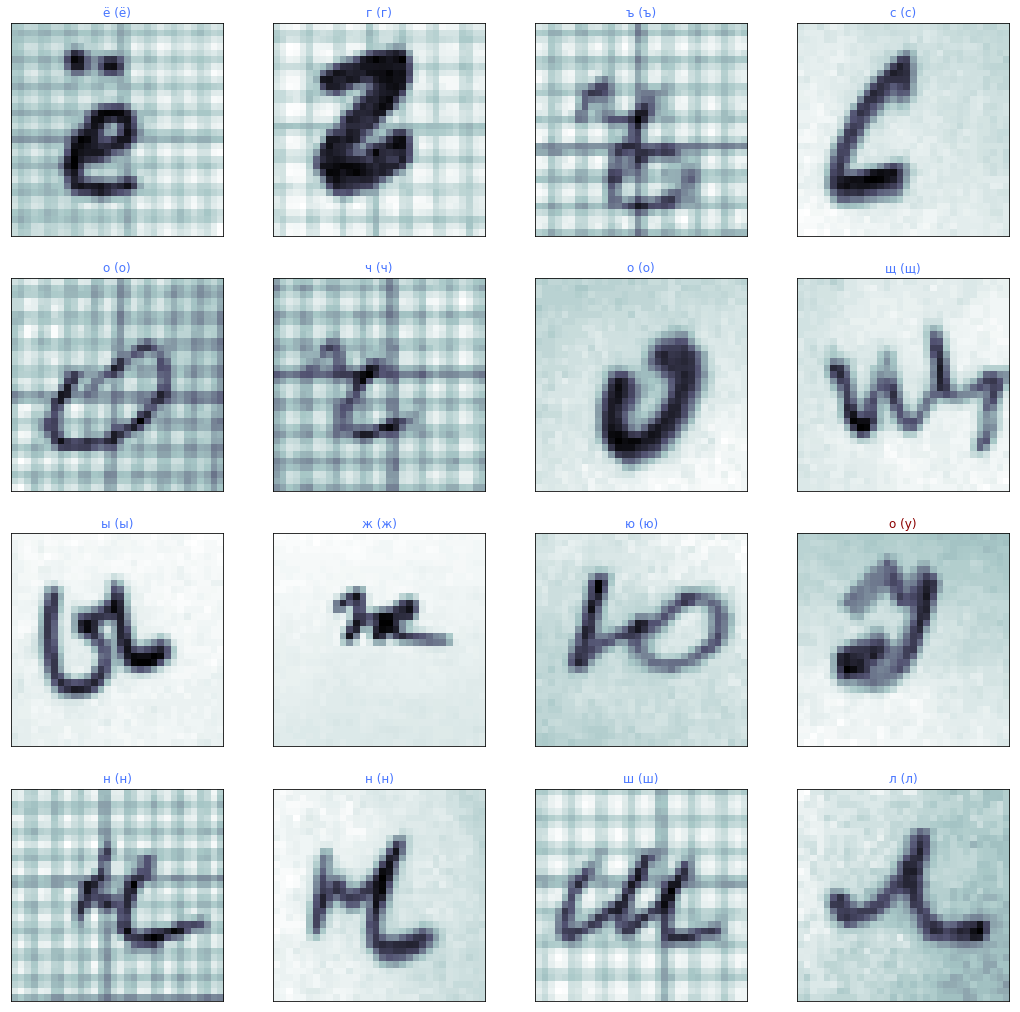

In [82]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test2.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test2[idx]), cmap=cm.bone)
    pred_idx = y_test2_predict[idx]
    true_idx = np.argmax(y_test2[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))